# Project for the Optimization for Data Science lecture

*Authors* : Alexandre Gramfort, Stéphane Gaiffas

## Objectives of the project

The aim of this project is to implement and use matrix factorization 
techniques to improve a classification problem. Namely, we will use the coefficients 
(also called codes or sparse codes below) as new features, instead of the raw features 
(here pixels from face images). The algorithms will be applied on a labelled face dataset.

## Description of the data

You will use the "Labeled Faces in the Wild" face recognition dataset.
This dataset is a collection of JPEG pictures of famous people collected over the internet,
all details are available on the official website: http://vis-www.cs.umass.edu/lfw/.
The downloading and preprocessing of the dataset is done is the code below.

## Step-by-step objectives 

1. Read and understand classification of the faces using the raw images
- Read and understand classification using features coming out of the SVD
- Code a routine doing (batch) dictionary learning
- Classification of the faces using the sparse code coming out of a dictionary learning as features.
- Compare all solutions in terms of accuracy of classification
- Try to improve the routine for dictionary learning using an online approach

## Notes

You will use **only** simple kNN (k-nearest neighbour) classification for the project.
The focus is on the benefits of using a matrix factorization technique (SVD, NMF, sparse dictionary learning) prior to a classification problem, to obtain better and more expressive features for classification.
In summary, the different methods to compare are the following:


1. kNN on raw features
- kNN on SVD/PCA features
- kNN on batch sparse dictionary learning features
- kNN on batch sparse dictionary learning features with non-negativity constraints
- kNN on online dictinoary learning features

## Evaluation

For evaluation of the project, we will look at what you have been able to implement, but also on the quality of your comments and explanations.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Download and load the face dataset

**NOTE**: this might take some time depending on your connection. 
Don't hesitate to wait and try several times.

In [2]:
from sklearn import decomposition

# fetch_lfw_people is the routine that download the data for you
from sklearn.datasets import fetch_lfw_people

# Download faces data
dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# X contains the 1288 flattened images
X = dataset.data
# X contains the 1288 images of size (50, 37)
images = dataset.images
# y contains the targets: the label to be predicted
y = dataset.target
# target_names contains the name corresponding to the target
target_names = dataset.target_names

## Let's plot a subset of the data

In [3]:
images.shape

(1288, 50, 37)

The dataset contains $1288$ images of size $50 \times 37$ pixels. Let's plot the first ones.

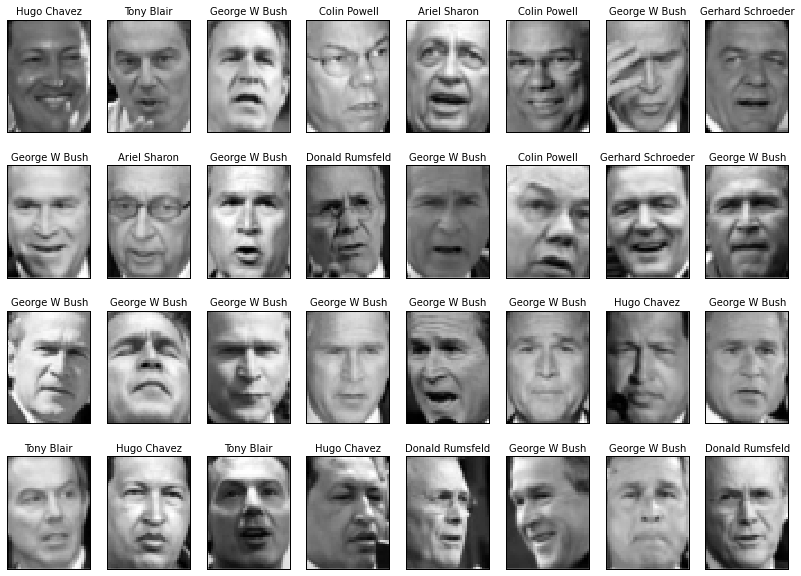

In [4]:
plt.figure(figsize=(14, 10))

n_rows, n_cols = 4, 8
for k in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, k + 1)
    plt.imshow(images[k], cmap=plt.cm.gray, interpolation='none')
    plt.xticks(())
    plt.yticks(())    
    plt.title(target_names[y[k]], size=10)

## Main objective

The aim will be to predict the label (name of the person's face) based on its picture.
To achieve this, we'll use a very simple classifier (kNN), but on features learned from a 
factorization of the $(1288 \times 1850)$ matrix `X` containing all flattened faces.
Once again, `images` contains the faces, while `X` contains the flattened faces.

This means that 

    X[k].reshape(50, 37)

is the same as

    images[k]

for all images `k` between 0 and 1287.

When applying matrix factorization and dictionary learning, it we will work on the flattened version below, contained in `X`, see below.

## Matrix factorization

Let us denote the number of samples $n$ and the number of features $p$ such that, following scikit-learn conventions, we have $X \in \mathbb{R}^{n \times p}$.

We are interested in factorizing the matrix $X^\top$ introducing a matrix $D \in \mathbb{R}^{p \times k}$ that we will call the *dictionary* and a matrix $A \in \mathbb{R}^{k \times n}$ that we will call the *code*. It is called the code as each column $i$ of $A$ contains the coeffecients for the sample $i$. The code is in dimension $k$ which corresponds to the number of columns in $D$. We will say that $k$ is the number of *atoms* in the dictionary.

The matrix $D$ and $A$ should verify that $X^\top \approx DA$

Matrix factorization in an unsupervised problem for which performance is hard to evaluate. In order to have an objective metric for the quality of the code $A$ we will use the code as new features using a k-NN (k=1) classifier.

We will now illustrate this using Singular Value Decomposition (SVD). The different variants of dictionary learning boil down to imposing different constraints on $D$ or $A$.

## Preprocessing : centering of the data

In [5]:
n_samples, n_features = X.shape

# global centering
X_centered = X - X.mean(axis=0)

# local centering
X_centered -= X_centered.mean(axis=1).reshape(n_samples, -1)

In [6]:
def plot_faces(faces, n_rows=4, n_cols=8, label=True):
    plt.figure(figsize=(14, 10))
    n_rows, n_cols = 4, 8
    face_shape = (50, 37)
    for k, flat_face in enumerate(faces):
        if k >= n_rows * n_cols:
            break
        face = flat_face.reshape(face_shape)
        plt.subplot(n_rows, n_cols, k+1)
        plt.imshow(face, cmap=plt.cm.gray, interpolation='none')
        plt.xticks(())
        plt.yticks(())
        if label:
            plt.title(target_names[y[k]], size=10)

The data looks that this now

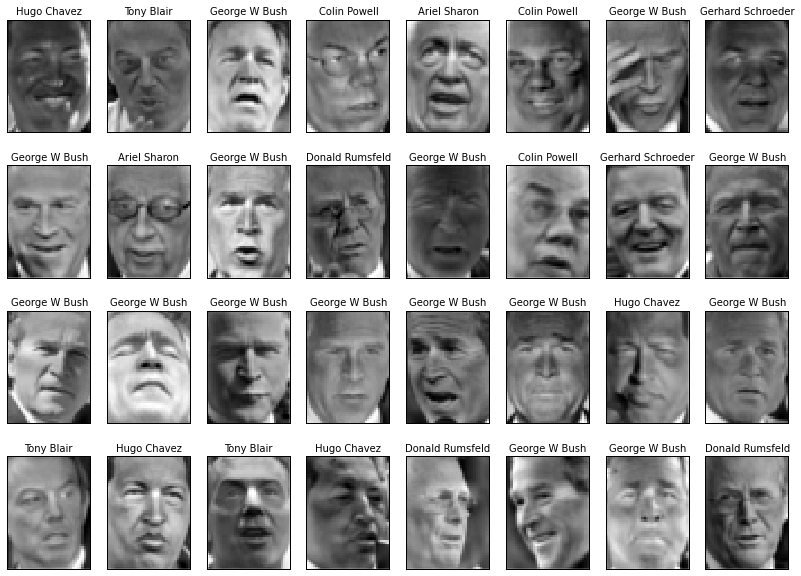

In [7]:
plot_faces(X_centered)

# Classification with kNN using the raw faces

First, we use a simple kNN classifier on the raw features (flattened faces, namely the lines of `X`). All evaluations are done by looking at the cross-validation score

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# The kNN classifier
clf = KNeighborsClassifier(n_neighbors=1)

# Compute the cross-validation score of kNN on the raw features
scores_raw = cross_val_score(clf, X_centered, y, cv=2)
score_raw = np.mean(scores_raw)

print("Cross-validation score using raw features : %s" % scores_raw)

Cross-validation score using raw features : [ 0.59597523  0.59968847]


# Classification with kNN using the SVD features

In [9]:
from sklearn.decomposition import PCA
from scipy import linalg

# Apply SVD with on X_centered and get the D and A matrices
U, S, Vh = linalg.svd(X_centered.T, full_matrices=False)
D = U * S
A = Vh

Let's visualize the atoms

They look ugly... and are something referred to as "eigen faces".

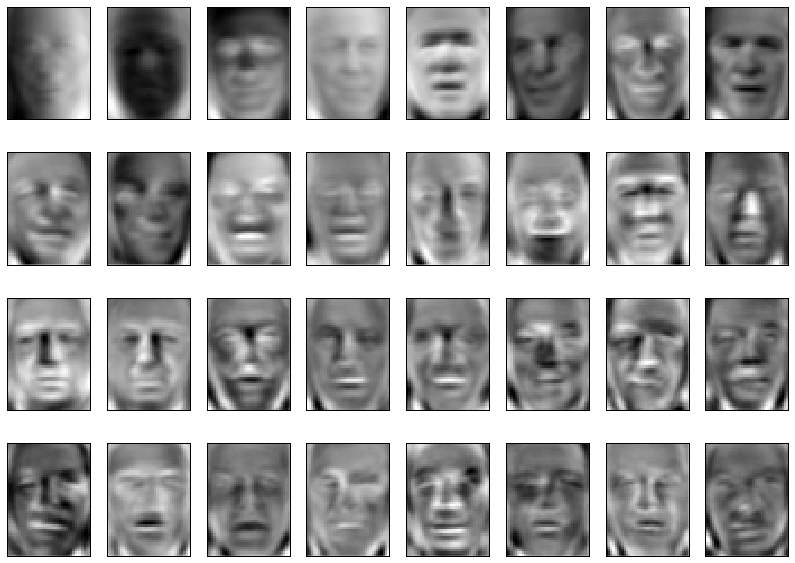

In [10]:
plot_faces(D.T, label=False)

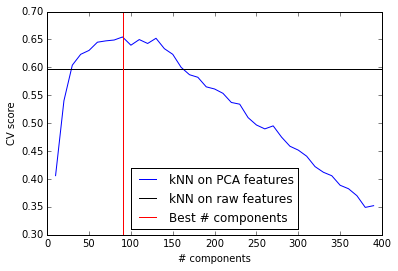

In [11]:
# Compute the cross-validation score of kNN on the new features obtained by PCA
clf = KNeighborsClassifier(n_neighbors=1)

scores_pca = []
n_components_range = np.arange(10, 400, 10)
for n_components in n_components_range:
    # n_components is the rank used in the SVD when fitting the PCA
    X_pca = A[:n_components, :].T
    score_pca = cross_val_score(clf, X_pca, y, cv=2).mean()
    scores_pca.append(score_pca)

plt.plot(n_components_range, scores_pca, label='kNN on PCA features')
plt.axhline(np.mean(score_raw), color='k', label='kNN on raw features')
plt.axvline(n_components_range[np.argmax(scores_pca)], color='r', label='Best # components')
plt.legend(loc='best')
plt.xlabel('# components')
plt.ylabel('CV score')

In summary, the features coming from SVD give a good improvement over the use of the raw features. Yet the atoms obtained with an SVD have no contraints: they don't have positive entries, and the new features don't have any sparsity properties. The idea is change the constraints on $D$ and $A$ during estimation to obtain good features.

# Classification with kNN using dictionary learning

The problem of sparse dictionary learning reads

$$
\min_{D,A} \frac{1}{2} \|X^\top - DA\|^2 + \lambda \|A\|_1
$$
$$ X^T \in \mathbb{R}^{p \times n}, D \in \mathbb{R}^{p \times k}, A \in \mathbb{R}^{k \times n}$$

under the constraints that the norm of each atom $\|D_i\| \le 1, \forall 1 \le i \le k$.
Here $\|A\|_1 = \sum_{i,j} |A_{ij}|$, i.e. it's the sum of the $\ell_1$ norm of each column of A.

This model was for example proposed in:

http://www.jmlr.org/papers/volume11/mairal10a/mairal10a.pdf [1]

## Question 1: 
### Try 1:

* The primal problem can be written as :
$$
\min_{D \in C,A}\sum_i \frac{1}{2} \|X_i^\top - DA_i\|^2 + \lambda \|A_i\|_1 \\
with \ C = \{ D \in R^{P*K} \ s.t. \ \forall 1 \le i \le k, D_i^TD_i \le 1 \}\ 
$$

* I have decided to use stochastic gradient descent to resolve the problem. The reason of this choice was mainly because the machine we used for the computations don't have a lot of memory. We were happy to see that [1] concluded that schochatics gradient descent approaches give better results than the other approaches.

* The optimization problem we have to solve is not jointly convex but but convex with respect to each of the two variables D (least square + orthogonal projection) and A (Lasso) <br\>
    Therefore, we will use an alternating method to resolve this problem. Proof of convergence of such methods can be found in [1]. \\
    The framework we will use will look like :
    - Initialize $D_0$ and $A_0$
    - For t = 1, 2, . . . until convergence do
        - Pick at random (uniformly) i in {1, . . . , n}
        - $A_i^t = argmin_{A_i \in \mathbb{R}^k}\frac{1}{2} \|X_i^\top - DA_i\|^2 + \lambda \|A_i\|_1 $
        - $D_t = \Pi_C((D_{t-1} - \lambda_k \nabla l_i(D_{t-1}) = \Pi_C(D_{t-1} - \lambda_k (DA_i - X_i^\top)A_i^T)$
        <br />Note that the projection is simply done by normailising the columns of D
        

In [28]:
from sklearn.linear_model import Lasso

def SGD(k=50,alpha=0.07,eta=1):
    A = np.eye(k,n_samples)
    D = np.eye(n_features,k)
    X_ct = X_centered.transpose()
    T=3
    for t in range(T):
        for i in range(n_samples): 
            idx=int(np.floor(np.random.uniform(0,1288)))
            Xi = X_ct[:,idx]
            clf = Lasso(alpha=alpha,fit_intercept=False,warm_start=True) #max_iter=30
            clf.fit(D.astype(np.float),Xi.astype(np.float))
            Ai = clf.coef_
            A[:,i] = Ai
            Ai = Ai[:,np.newaxis]
            Xi = Xi[:,np.newaxis]
            D=D-(eta/np.sqrt(t*n_samples+i+1))*(D.dot(Ai)-Xi).dot(Ai.transpose())
            for l in range(D.shape[1]):
                n = np.linalg.norm(D[:,l])
                if (n>1):
                    D[:,l]=D[:,l]/n
            if i%500==0:
                print np.linalg.norm(X_ct-np.dot(D,A))
#                 print i
    return A,D

52258.3650182
53492.0352689
54657.7577447
55499.0764617
55658.9346914
55657.6265159
55433.3563092
56011.2224678
55682.3777727


0.23601265395484311

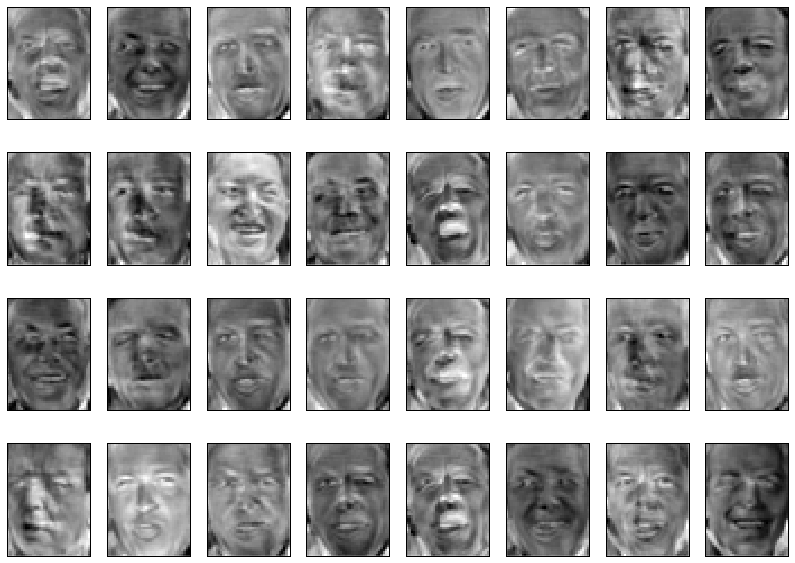

In [29]:
A,D = SGD(k=90,alpha=0.05,eta=1)
plot_faces(np.transpose(np.dot(D,A)), label=False)
cross_val_score(clf, A.T, y, cv=2).mean()

#### Partial Conclusion:
This algorithm was tested for different values of the parameters k, alpha and eta. However I was not able to make it converge. <br />
#### Try 2:
To resolve the problem, I have then decided to use a batch alternating gradient descent algorithm:
- Initialize $D_0$ and $A_0$
- For t = 1, 2, . . . until convergence do
    - $A^t = argmin_{A \in \mathbb{R}^{k*n}}\frac{1}{2} \|X^\top - DA\|^2 + \lambda \|A\|_1 $
    <br /> A fista algorithm algorithm was then used. 3 parameters were needed: 
        - The maximum number of iterations (An early stop was added to enanable the algorithm to stop when close to convergence). 
        - The step of the fista algorithm. It is recommended to be in the order of $\frac{n_samples}{max eigenvalue(D)}$ but it was set manually
        - The lasso parameter $\lambda$
    - $D_t = \Pi_C(argmin_{D \in \mathbb{R}^{p*k}}\frac{1}{2} \|X^\top - DA\|^2 + \lambda \|A\|_1) = \Pi_C(X^\top A^\top (A A^\top)^{-1})$

In [12]:
def prox_lasso(x, l_l1):
    """Proximal operator for the L1 norm / Lasso at x"""
    x_abs = np.abs(x)
    return np.sign(x) * np.maximum(x_abs - l_l1, 0)

def grad_f(x,D,X_ct):
#     return (A.T.dot(A).dot(x)-A.T.dot(b))/n_samples
    return D.T.dot(D.dot(x)-X_ct)#/n_samples

def fista(x0, D,X_ct,l_l1=0., l_l2=0., step=None, n_iter=50):
    x = x0.copy()
    x_new = x0.copy()
    nu=1
    z_t = x0.copy()
    
    def g(x):
        return enet(x, l_l1, l_l2)

    def prox_g(x, t):
        """Proximal operator for the elastic net at x"""
        #x_abs = np.abs(x)
        #return np.sign(x) * np.maximum(x_abs - t*l_l1, 0)/(1+t*l_l2)
        return prox_lasso(x, l_l1)
            
    
    if step is None:
        step = n_samples/L  # TODO
    t=step   
 
#     print "Lauching FISTA solver..."    
    for k in range(n_iter):
        # ISTA update
        x_new[:] = prox_g(z_t-t*grad_f(z_t,D,X_ct), t)
        nu_2 = np.sqrt(nu**2 + (1/4.0))+(1/2.0)
        #nu_2 = (k+1)/2.0
        z_t = x_new + ((nu-1)/(nu_2))*(x_new-x)
        nu = nu_2
        x[:] = x_new
        #x[:] = x  # TODO
    return x

In [13]:
def alternateGD(k=50,alpha=0.07,n_iter=15,n_iter_fista=10,step_fista=0.1):
    #Fista paramters
    n_iter_fista = n_iter_fista
    l_l1 = alpha
    step=step_fista
    # x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter)
    T=n_iter
    A = np.eye(k,n_samples)
    D = np.eye(n_features,k)
    X_ct = X_centered.transpose()
    delta = 0
    for t in range(T):
        A = fista(A,D,X_ct,step=step, l_l1=l_l1, n_iter=n_iter_fista)
        #update de D
        C=np.linalg.pinv(A.dot(A.transpose()))
        D=X_ct.dot(A.transpose().dot(C))
        for i in range(k):
            n = np.linalg.norm(D[:,i])
            if (n>1):
                D[:,i]=D[:,i]/n
        #Early Stop
        if t%10==0:
            delta2 = np.linalg.norm(X_ct-np.dot(D,A))
#             print delta2
            if np.abs(delta-delta2)<5:
#                 print "break"
                break
            delta = delta2
    return A,D

50778.0462632
16671.0913
16649.050206
16646.3803757
break


0.61414359152416509

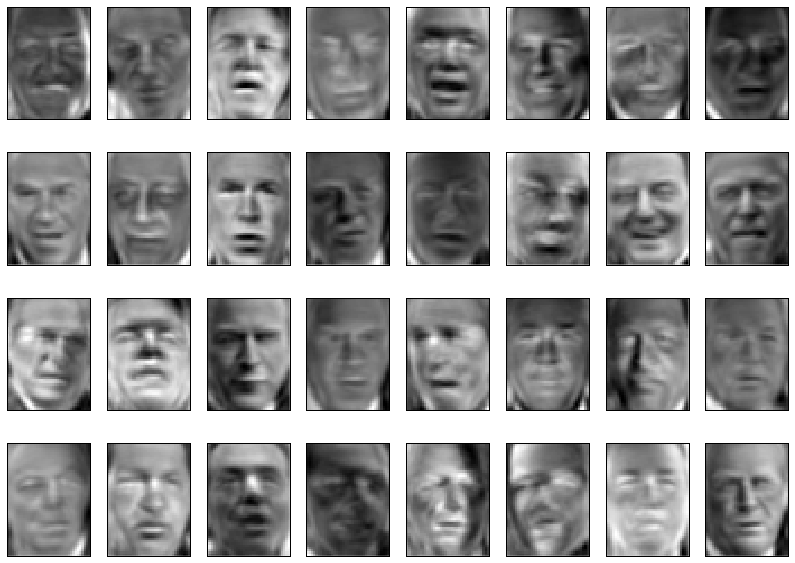

In [35]:
A,D = alternateGD(k=90,alpha=0.05,n_iter=100,n_iter_fista=10,step_fista=0.1)
plot_faces(np.transpose(np.dot(D,A)), label=False)
cross_val_score(clf, A.T, y, cv=2).mean()

## Question 2:
For this part I used the same algorithm as previously (Fista to update D and pseudo inversion for A)

In [42]:
def prox_lasso(x, l_l1):
    """Proximal operator for the L1 norm / Lasso at x"""
    x_abs = np.abs(x)
    return np.sign(x) * np.maximum(x_abs - l_l1, 0)

def grad_f(x,A,X_ct):
#     return (A.T.dot(A).dot(x)-A.T.dot(b))/n_samples
    return (x.dot(A)-X_ct).dot(A.T)

def fista(x0, D,X_ct,l_l1=0., l_l2=0., step=None, n_iter=50):
    x = x0.copy()
    x_new = x0.copy()
    nu=1
    z_t = x0.copy()
    
    def g(x):
        return enet(x, l_l1, l_l2)

    def prox_g(x, t):
        """Proximal operator for the elastic net at x"""
        #x_abs = np.abs(x)
        #return np.sign(x) * np.maximum(x_abs - t*l_l1, 0)/(1+t*l_l2)
        return prox_lasso(x, l_l1)
            
    
    if step is None:
        step = n_samples/L  # TODO
    t=step   
 
#     print "Lauching FISTA solver..."    
    for k in range(n_iter):
        # ISTA update
        x_new[:] = prox_g(z_t-t*grad_f(z_t,D,X_ct), t)
        nu_2 = np.sqrt(nu**2 + (1/4.0))+(1/2.0)
        #nu_2 = (k+1)/2.0
        z_t = x_new + ((nu-1)/(nu_2))*(x_new-x)
        nu = nu_2
        x[:] = x_new
        #x[:] = x  # TODO
    return x

def alternateGD2(k=50,alpha=0.07,n_iter=15,n_iter_fista=10,step_fista=0.1):
    #Fista paramters
    n_iter_fista = n_iter_fista
    l_l1 = alpha
    step=step_fista
    # x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter)
    T=n_iter
    A = np.eye(k,n_samples)
    D = np.eye(n_features,k)
#     X_ct = X.transpose()
    X_ct = X_centered.transpose()
    delta = 0
    for t in range(T):
        #update de D
        D = fista(D,A,X_ct,step=step, l_l1=l_l1, n_iter=n_iter_fista)
        #update de A
        C=np.linalg.pinv(D.T.dot(D))
        A = C.dot(D.T).dot(X_ct)
        for i in range(k):
            n = np.linalg.norm(A[i,:])
            if (n>1):
                D[i,:]=D[i,:]/n
        #Early Stop
        if t%10==0:
            delta2 = np.linalg.norm(X_ct-np.dot(D,A))
#             print delta2
            if np.abs(delta-delta2)<10:
#                 print "break"
                break
            delta = delta2
    return A,D

# Question 3: Impact of l1 norm

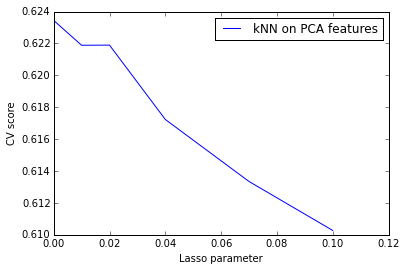

In [32]:
# Compute the cross-validation score of kNN on the new features obtained by PCA
clf = KNeighborsClassifier(n_neighbors=1)

n_components_range = np.arange(60, 140,10)
# alphas = np.linspace(0,0.1,5)
alphas = np.concatenate((np.linspace(0,0.02,3),[0.04,0.07,0.1]),axis=0)

scores = np.zeros([alphas.shape[0],n_components_range.shape[0]])
for i1,alpha in enumerate(alphas):
    for i2,n_components in enumerate(n_components_range):
        A,D = alternateGD(k=n_components,alpha=alpha,n_iter=100,n_iter_fista=10,step_fista=0.1)
        score = cross_val_score(clf, A.T, y, cv=2).mean()
        scores[i1,i2] = score
        print "alpha={}, k={}, Score= {}".format(alpha,n_components,score)

plt.plot(alphas, np.max(scores,axis=1), label='Best score for k<150')
plt.legend(loc='best')
plt.xlabel('Lasso parameter (Lambda)')
plt.ylabel('CV score')

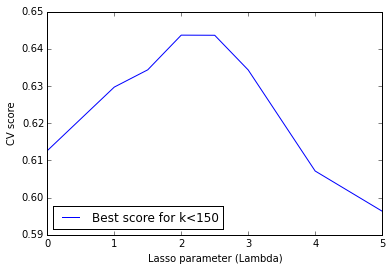

In [45]:
# Compute the cross-validation score of kNN on the new features obtained by PCA
clf = KNeighborsClassifier(n_neighbors=1)

n_components_range = np.arange(80, 110,10)
# alphas = np.linspace(0,0.1,5)
alphas = np.concatenate(([0],np.linspace(1,3,5),[4,5]),axis=0)

scores = np.zeros([alphas.shape[0],n_components_range.shape[0]])
for i1,alpha in enumerate(alphas):
    for i2,n_components in enumerate(n_components_range):
        A,D = alternateGD2(k=n_components,alpha=alpha,n_iter=50,n_iter_fista=10,step_fista=2)
        score = cross_val_score(clf, A.T, y, cv=2).mean()
        scores[i1,i2] = score
        print "alpha={}, k={}, Score= {}".format(alpha,n_components,score)
        
plt.plot(alphas, np.max(scores,axis=1), label='Best score for k<150')
plt.legend(loc='best')
plt.xlabel('Lasso parameter (Lambda)')
plt.ylabel('CV score')

1-  From the last two graphs, we can clearly see that, the more we increase the weigth of the l1 penalty, the more we loose information useful for the classification tasks. This means then that the matrix A is not likely to be sparse (sparsity constraints don't work well). 
<br /> One way I can explain that is by the fact that, for each image i, the values in the vector Ai are the coefficients of that image on the columns of the dictionnary (the atoms). Ist is then normal that, for an optimal number of atoms k, that all of the columns play a role in the representation of each image.

2- The previous figure make us see that some choices of the values the Lasso regularization parameter yield to good classification performance which mean that the columns of the dictionnary can be sparses. 

### Visual Impact of l1 norm on the atoms

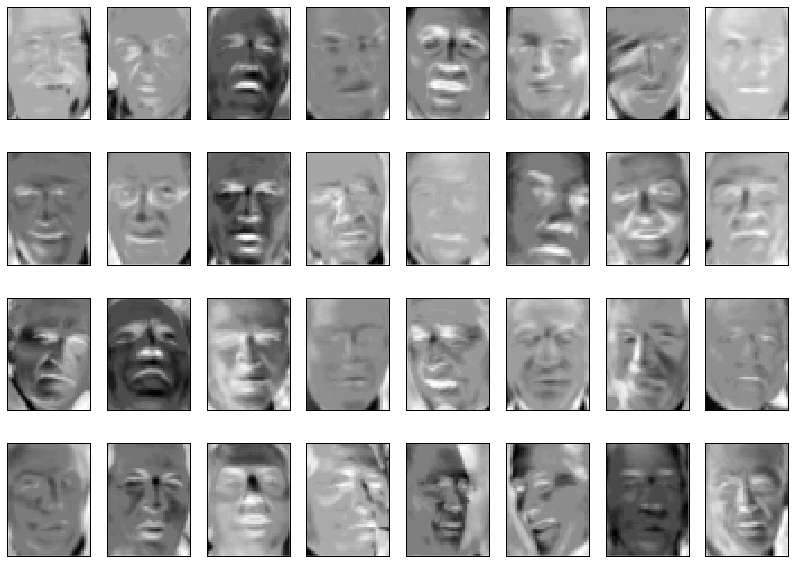

In [46]:
A,D = alternateGD2(k=90,alpha=2,n_iter=50,n_iter_fista=10,step_fista=2)
plot_faces(D.T, label=False)

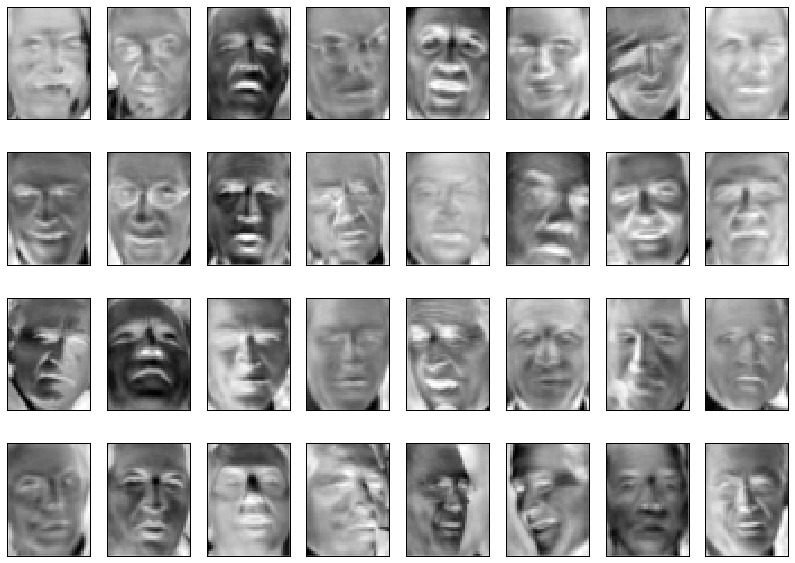

In [47]:
A,D = alternateGD2(k=90,alpha=0,n_iter=50,n_iter_fista=10,step_fista=2)
plot_faces(D.T, label=False)

It is very difficult to find big differences between those atoms visually. The ones obtained after regularization look a litle bit filtered

# Question 4 : non-negativity

### Try 1
To add non negative constraints, I first simply modify my previous algorithms by simply projecting A and D on the space of matrices of non negative value (I put all the negatives values to zero). 
<br /> That procedure gave very bad results and I think it is because we can quickly be stuck in a local minimum (I doubt that the problem is still very convex in D and A)

In [48]:
def prox_lasso(x, l_l1):
    """Proximal operator for the L1 norm / Lasso at x"""
    x_abs = np.abs(x)
    return np.sign(x) * np.maximum(x_abs - l_l1, 0)

def grad_f(x,D,X_ct):
#     return (A.T.dot(A).dot(x)-A.T.dot(b))/n_samples
    return D.T.dot(D.dot(x)-X_ct)#/n_samples

def fista(x0, D,X_ct,l_l1=0., l_l2=0., step=None, n_iter=50):
    x = x0.copy()
    x_new = x0.copy()
    nu=1
    z_t = x0.copy()
    
    def g(x):
        return enet(x, l_l1, l_l2)

    def prox_g(x, t):
        """Proximal operator for the elastic net at x"""
        #x_abs = np.abs(x)
        #return np.sign(x) * np.maximum(x_abs - t*l_l1, 0)/(1+t*l_l2)
        return prox_lasso(x, l_l1)
            
    
    if step is None:
        step = n_samples/L  # TODO
    t=step   
 
#     print "Lauching FISTA solver..."    
    for k in range(n_iter):
        # ISTA update
        x_new[:] = prox_g(z_t-t*grad_f(z_t,D,X_ct), t)
        nu_2 = np.sqrt(nu**2 + (1/4.0))+(1/2.0)
        #nu_2 = (k+1)/2.0
        z_t = x_new + ((nu-1)/(nu_2))*(x_new-x)
        nu = nu_2
        x[:] = x_new
        #x[:] = x  # TODO
    return x

def NMF(k=50,alpha=0.07,n_iter=15,n_iter_fista=10,step_fista=0.1):
    #Fista paramters
    n_iter_fista = n_iter_fista
    l_l1 = alpha
    step=step_fista
    # x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter)
    T=n_iter
    A = np.eye(k,n_samples)
    D = np.eye(n_features,k)
#     X_ct = X_centered.transpose()
    X_ct = X.transpose()
    delta = 0
    for t in range(T):
        A = fista(A,D,X_ct,step=step, l_l1=l_l1, n_iter=n_iter_fista)
        A[A<0] = 0
        #update de D
        C=np.linalg.pinv(A.dot(A.transpose()))
        D=X_ct.dot(A.transpose().dot(C))
        D[D<0] = 0
        for i in range(k):
            n = np.linalg.norm(D[:,i])
            if (n>1):
                D[:,i]=D[:,i]/n
        #Early Stop
        if t%10==0:
            delta2 = np.linalg.norm(X_ct-np.dot(D,A))
            print delta2
            if np.abs(delta-delta2)<5:
                print "break"
                break
            delta = delta2
    return A,D

128228.996627
62361.660254
47519.5286827
42225.617277
39253.5066653
37588.4183058
36652.4768445
36296.1020161
36078.9585531
35910.5105311


0.54496397673678421

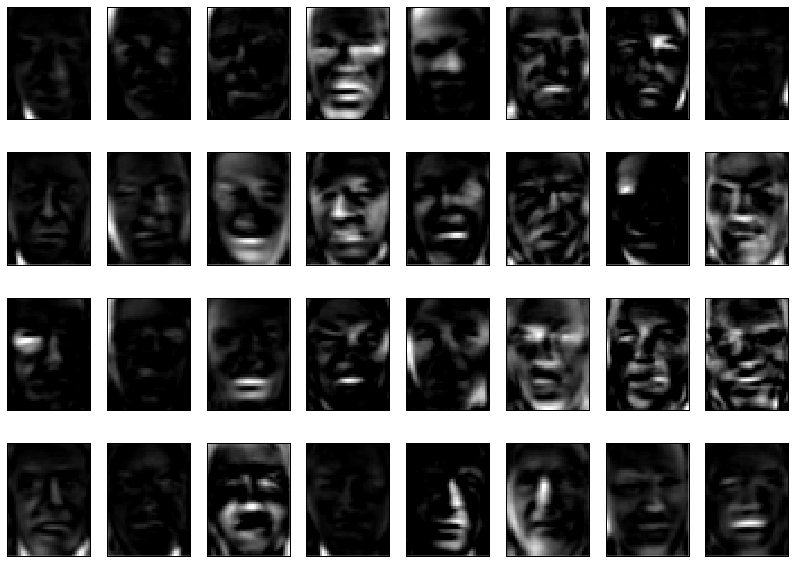

In [49]:
A,D = NMF(k=90,alpha=0.01,n_iter=100,n_iter_fista=20,step_fista=0.01)
plot_faces(D.T, label=False)
cross_val_score(clf, A.T, y, cv=2).mean()

### Try 2 :
I also look at other ways of tackling the problem of matrix factorization in the litterature. I found an article where an interresting procedure for updating D and A is proposed: http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf 
<br /> That procedure is inspired from gradient descent with smart choice of the step sizes. A proof on convergence is also given. 
<br /> However, I wasn't able to add a l1 norm penalisation using that procedure

In [50]:
from sklearn.linear_model import Lasso

# X = DA
def NMF(k=50,n_iter=100):
    D = np.abs(np.random.randn(n_samples,k))
    A = np.abs(np.random.randn(k,n_features))
    T=n_iter
    delta = 0
    for t in range(T):
        #update de A
        
        D = np.multiply(D,np.divide(X.dot(A.T),D.dot(A).dot(A.T)))
        A = np.multiply(A,np.divide(D.T.dot(X),D.T.dot(D).dot(A)))
        
        
        for i in range(k):
            n = np.linalg.norm(A[i,:])
            if (n>1):
                A[i,:]=A[i,:]/n
        if t%100==0:
            delta2 = np.linalg.norm(X-np.dot(D,A))
            print delta2
            if np.abs(delta-delta2)<300:
                print "break"
                break
            delta = delta2

    return A,D

0.62419104385482671

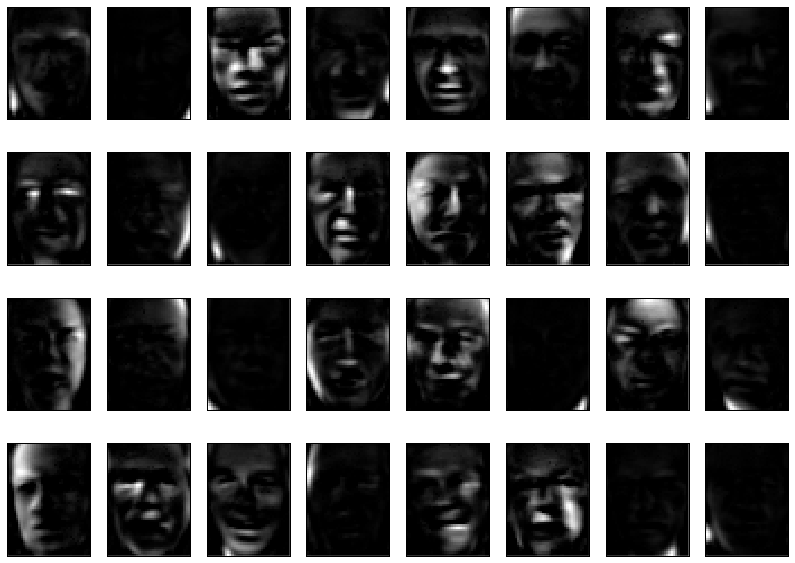

In [54]:
A,D = NMF(k=90,n_iter=1000)
plot_faces(A, label=False)
cross_val_score(clf, D, y, cv=2).mean()

I don't see an increase of perfomance by adding the non negative penalization

# Question 5 : Julien Mairal Method
Below is an attenmpt of implementation of the algorithm proposed by julien Mairal https://arxiv.org/abs/0908.0050. 
<br />  This implementation unfortunately doesn't converge.

In [60]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
def mairal(k=100,n_iter=100,alpha=0.01):
    A_real = np.eye(k,n_samples)
    A=np.zeros([k,k])
    B=np.zeros([n_features,k])
    D = np.eye(n_features,k)
#     D = np.abs(np.random.randn(n_features,k))
    T=n_iter
    X_ct = X_centered.transpose()
    for t in range(T):
        i=int(np.floor(np.random.uniform(0,1288)))
        Xi=X_ct[:,i]
#         clf = LassoLars(alpha=0.05,fit_intercept=False)
        clf = Lars()
        clf.fit(D.astype(np.float),Xi.astype(np.float))
        A_real[:,i] = clf.coef_
        alpha = np.matrix(clf.coef_)
#         print (alpha.shape)
        A = A+alpha.T.dot(alpha)
        xt=np.matrix(Xi)
        B = B+xt.T.dot(alpha)
        for j in range(k):
            aj = np.matrix(A[:,j])
            bj = B[:,j]
            dj = D[:,j]
            uj = (1/A[j,j])*(bj-D.dot(aj)).T+dj
            nj = np.linalg.norm(uj)
            maxj = max(nj,1)
            dj = (1/maxj)*uj
            D[:,j] = dj
        if t%100==2:
            print np.linalg.norm(X_ct-np.dot(D,A_real))
    return A_real, D

52211.832762
2.97828773711e+35
1.99032219071e+39
1.98987437494e+39


0.14132500024111955

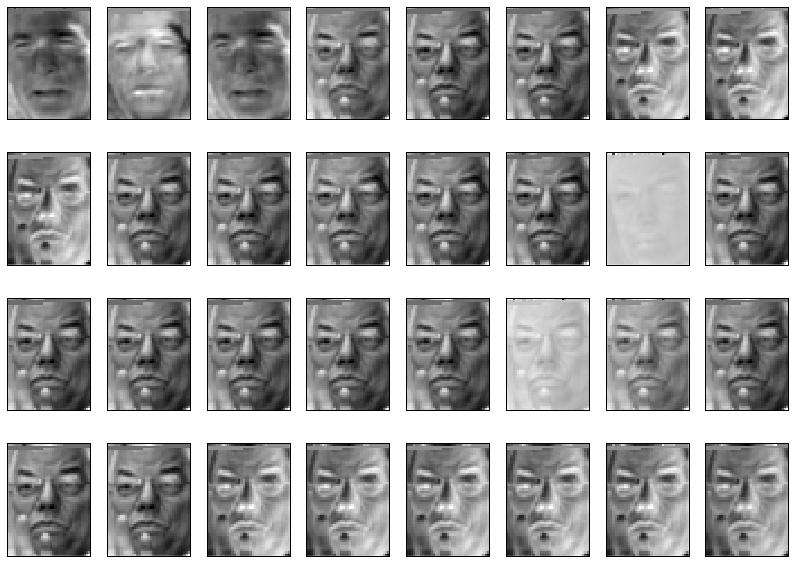

In [61]:
# %pdb
import warnings
warnings.filterwarnings("ignore")
A,D = mairal(k=90,n_iter=400,alpha=0.01)
plot_faces(D.T, label=False)
cross_val_score(clf, A.T, y, cv=2).mean()

# YOUR MISSION :

- Propose and implement a method to estimate $D$ and $A$ by minimization of the sparse dictionary learning cost function. You will notice that the function to minimize is not jointly convex in $D$ and $A$ but that it is convex in $D$ when $A$ is fixed and convex in $A$ when $D$ is fixed. This suggests that you can use an alternated minimization technique.
- Apply the solver you developped above to obtain $D$ and $A$ by solving
$$
\min_{D,A} \frac{1}{2} \|X^\top - DA\|^2 + \lambda \|D\|_1
$$
subject to $\|A_i\| \le 1, \forall 1 \le i \le k$ (here $A_i$ stands for the $i^{th}$ row of $A$.
- As it was done with SVD above, evaluate the quality of the code with k-NN and visualize the atoms. What is the impact of the $\ell_1$ norm penalty on the atoms? You should observe that you will need to find a good $\lambda$.
- Add a non-negativity constraint on $D$ and $A$, i.e. $D_{ij} \geq 0$ and $A_{ij} \geq 0$. Does it improve the performance?
- Implement the online method from Mairal et al. (http://www.jmlr.org/papers/volume11/mairal10a/mairal10a.pdf).

WARNING: Some preprocessing of $X$ such as centering does not make sense if you use non-negativity constraints.